In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from features import extract_features
from windows import slide_window, search_windows
from annotate import draw_boxes, draw_labeled_bboxes
from heat import add_heat, apply_threshold
from parameters import *
from train_svm import train
from scipy.ndimage.measurements import label

print("Done Importing")

Done Importing


In [2]:
if RETRAIN_MODEL is True:
    # Use the following two lines to generate txt files to store the filenames for vehicle and non-vehicle data
    # find vehicles -name '*.png' > vehicle-images.txt
    # find non-vehicles -name '*.png' > non-vehicle-images.txt
    # Iterate through the txt file and save the filenames as a list
    with open('./vehicle-images.txt', 'r') as f:
        car_filenames = f.read().splitlines() 
    n_cars = len(car_filenames)
    print("Numbers of vehicle dataset:", n_cars)

    with open('./non-vehicle-images.txt', 'r') as f:
        notcar_filenames = f.read().splitlines()
    n_notcars = len(notcar_filenames)
    print("Numbers of non vehicle dataset:", n_notcars)
    
    print("===== Start training model =====")
    train(car_filenames, notcar_filenames)

Numbers of vehicle dataset: 8792
Numbers of non vehicle dataset: 8968
===== Start training model =====
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
11.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9755


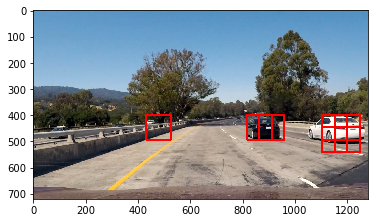

In [3]:
%matplotlib inline

image = cv2.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=X_START_STOP, y_start_stop=Y_START_STOP, 
                       xy_window=XY_WINDOW, xy_overlap=XY_OVERLAP)

with open(MODEL_FILE, mode='rb') as f:
    model_data = pickle.load(f)
model = model_data['svc']
X_scaler = model_data['X_scaler']
hot_windows = search_windows(image, windows, model, X_scaler, 
                             color_space=COLOR_SPACE, 
                             spatial_size=SPATIAL_SIZE, 
                             hist_bins=HIST_BINS, 
                             orient=ORIENT, 
                             pix_per_cell=PIX_PER_CELL, 
                             cell_per_block=CELL_PER_BLOCK, 
                             hog_channel=HOG_CHANNEL, 
                             spatial_feat=SPATIAL_FEAT, 
                             hist_feat=HIST_FEAT, 
                             hog_feat=HOG_FEAT)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))

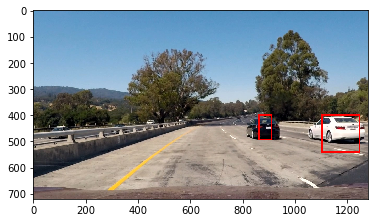

In [4]:
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)

window_img = draw_labeled_bboxes(draw_image, labels, color=(0, 0, 255), thick=6)                    

plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))